Douglas Rachford Proximal Splitting
===================================

$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$


This numerical tour presents the Douglas-Rachford (DR) algorithm to
minimize the sum of two simple functions. It shows an
application to
reconstruction of exactly sparse signal from noiseless measurement using
$\ell^1$ minimization.

In [1]:
from __future__ import division
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


Douglas-Rachford Algorithm
--------------------------
The Douglas-Rachford (DR) algorithm is an iterative scheme to minimize
functionals of the form
$$ \umin{x} f(x) + g(x) $$
where $f$ and $g$ are convex functions, of which one is able to
compute the proximity operators.

This algorithm was introduced in

P. L. Lions and B. Mercier
"Splitting Algorithms for the Sum of Two Nonlinear Operators,"
_SIAM Journal on Numerical Analysis_
vol. 16, no. 6, 1979,


as a generalization of an algorithm introduced by Douglas and Rachford in
the case of quadratic minimization (which corresponds to solving
a positive definite linear system).


To learn more about this algorithm, you can read:


Patrick L. Combettes and Jean-Christophe Pesquet,
"Proximal Splitting Methods in Signal Processing,"
in: _Fixed-Point Algorithms for Inverse
Problems in Science and Engineering_, New York: Springer-Verlag, 2010.



The Douglas-Rachford algorithm takes an arbitrary element $s^{(0)}$, a parameter $\ga>0$, a relaxation parameter $0<\rho<2$ and iterates, for $k=1,2,\ldots$
$$
\left|\begin{array}{l}
x^{(k)} = \mathrm{prox}_{\gamma f} (s^{(k-1)} )\\
s^{(k)} = s^{(k-1)}+\rho\big(\text{prox}_{\ga g}( 2x^{(k)}-s^{(k-1)})-x^{(k)}\big).
\end{array}\right.
$$

It is of course possible to inter-change the roles of $f$ and $g$,
which defines a different algorithm.

The iterates $x^{(k)}$ converge to a solution $x^\star$ of the problem, i.e. a minimizer of $f+g$.

Compressed Sensing Acquisition
------------------------------
Compressed sensing acquisition corresponds to a random projection
$y=Ax^\sharp$ of a signal $x^\sharp$ on a
few linear vectors (the rows of the matrix $A$). For the recovery of $x^\sharp$ to be possible, this vector is supposed
to be sparse in some basis. Here, we suppose $x^\sharp$ itself is sparse.

We initialize the random number generator for reproducibility.

In [2]:
random.seed(0)

Dimension of the problem.

In [3]:
N = 400

Number of measurements.

In [4]:
P = round(N/4)

We create a random Gaussian measurement matrix $A$.

In [5]:
A = randn(P,N) / sqrt(P)

Sparsity of the signal.

In [6]:
S = 17

We begin by generating a $S$-sparse signal $x^\sharp$ with $S$ randomized values.
Since the measurement matrix is random, one does not care about the sign
of the nonzero elements, so we set values equal to one.

In [7]:
sel = random.permutation(N)
sel = sel[0:S]   # indices of the nonzero elements of xsharp
xsharp = zeros(N)
xsharp[sel] = 1

We perform random measurements $y=Ax^\sharp$ without noise.

In [8]:
y = A.dot(xsharp) # matrix-vector multiplication in Python, more precisely dot product of a 2-D array with a 1-D array.

Compressed Sensing Recovery with the Douglas-Rachford algorithm
------------------------------------
Compressed sensing recovery corresponds
to solving the inverse problem $y=A x^\sharp$, which is ill posed because
$x^\sharp$ is
higher dimensional than $y$.


The reconstruction can be performed by $\ell^1$ minimization,
which regularizes the problem by exploiting the prior knowledge that the solution is sparse.
$$ x^\star \in \arg\min_x \norm{x}_1 \quad\mbox{s.t.}\quad Ax=y$$
where the $\ell^1$ norm is defined as
$$ \norm{x}_1 = \sum_{n=1}^N \abs{x_n}. $$


This is the minimization of a non-smooth function under affine
constraints. This can be shown to be equivalent to a linear programming
problem, for wich various algorithms can be used (simplex, interior
points). We propose here to use the Douglas-Rachford algorithm.


It is possible to recast this problem as the minimization of $f+g$
where $g(x) = \norm{x}_1$ and $f(x)=\iota_{\Omega}$ where $\Omega =
\enscond{x}{Ax=y}$ is an affine space, and $\iota_\Omega$ is the indicator
function
$$ \iota_\Omega(x) = \choice{ 0 \qifq x \in \Omega, \\ +\infty \qifq x \notin \Omega. } $$


The proximal operator of the $\ell^1$ norm is soft thresholding:
$$ \text{prox}_{\gamma \norm{\cdot}_1}(x)_n = \max\pa{ 0, 1-\frac{\ga}{\abs{x_n}} } x_n. $$

In [9]:
def prox_gamma_g (x, gamma) :
    return x - x/maximum(abs(x)/gamma,1) # soft-thresholding

Display the 1-D curve of the thresholding.

(-1.0, 1.0, -0.80000000000000004, 0.80000000000000004)

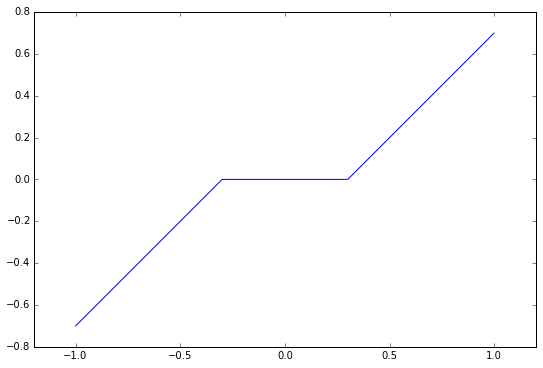

In [10]:
figsize(9,6)
t = arange(-1,1,0.001)
plot(t, prox_gamma_g(t,0.3))
axis('equal')

The proximity operator of $\gamma$ times the indicator function of $\Omega$ is projection onto $\Omega$ 
 and does not depends on $\gamma$.
$$ \mathrm{prox}_{\gamma f}(x)=\mathrm{prox}_{\iota_\Omega}(x)=P_\Omega(x)  = x + A^* (A A^*)^{-1} (y-Ax). $$

In [11]:
pA = pinv(A) # pseudo-inverse. Equivalent to pA = A.T.dot(inv(A.dot(A.T)))
def prox_f (x, y) :
    return x + pA.dot(y-A.dot(x))

We set the values of $\gamma$ and $\rho$.
Try different values to speed up the convergence.

In [12]:
gamma = 0.1 # try 1, 10, 0.1
rho = 1     # try 1, 1.5, 1.9

Number of iterations.

In [13]:
nbiter = 700

__Exercise__ 

Implement nbiter iterations of the Douglas-Rachford algorithm.
Keep track of the evolution of the $\ell^1$ norm.

In [14]:
s = zeros(N)
En_array = zeros(nbiter)
for iter in range(nbiter):  # iter goes from 0 to nbiter-1
    # put your code here
    En_array[iter] = norm(x, ord=1)  
x_restored = x


We display the original and the recovered signals.

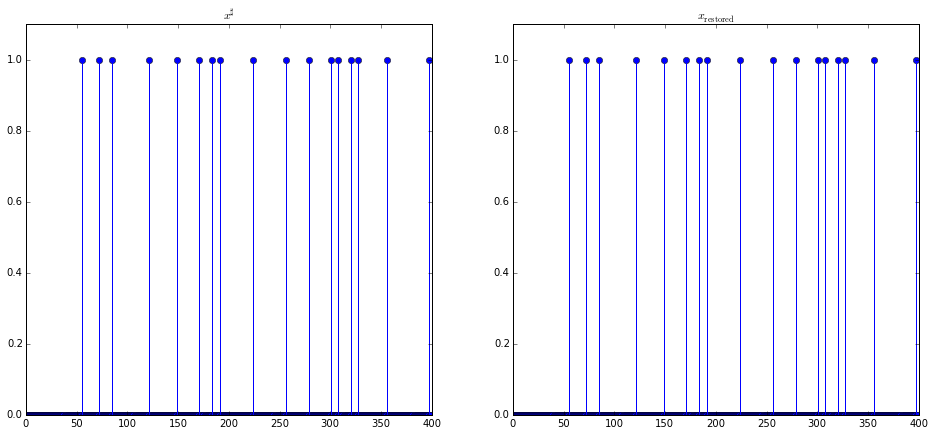

In [15]:
fig, (subfig1,subfig2) = subplots(1,2,figsize=(16,7)) # one figure with two horizontal subfigures
subfig1.stem(xsharp)
subfig1.set_ylim(0,1.1)
subfig2.stem(x_restored)
subfig2.set_ylim(0,1.1)
subfig1.set_title('$x^\sharp$')
subfig2.set_title('$x_\mathrm{restored}$')

Since the original signal is highly sparse, it is perfectly recovered.

We display the convergence speed of the $\ell^1$ norm on the first half iterations, in log
scale.

/Users/condatl/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


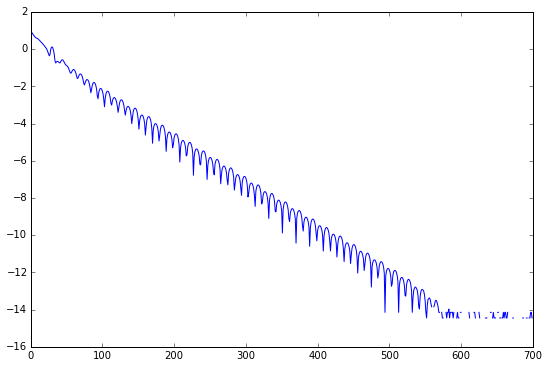

In [16]:
plot(log10(En_array-En_array.min()))

The convergence is linear in practice. Convergence up to machine precision (1e-14 here) is achieved after a few hundreds of iterations.

__Exercise__ 

Test the recovery of a less sparse signal.
What do you observe?

In [17]:
S = 31
random.seed(0)
sel = random.permutation(N)
sel = sel[0:S]   # indices of the nonzero elements of xsharp
xsharp = zeros(N)
xsharp[sel] = 1

y = A.dot(xsharp)

# put your code here

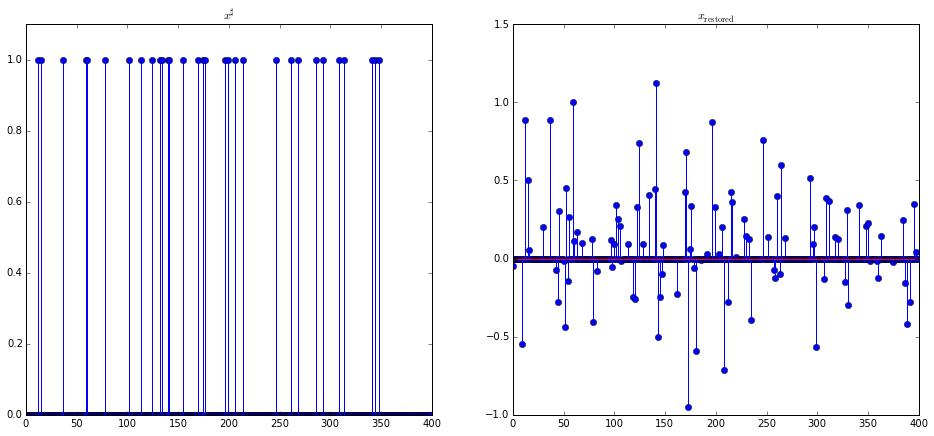

In [18]:
fig, (subfig1,subfig2) = subplots(1,2,figsize=(16,7)) # one figure with two horizontal subfigures
subfig1.stem(xsharp)
subfig1.set_ylim(0,1.1)
subfig2.stem(x_restored)
subfig1.set_title('$x^\sharp$')
subfig2.set_title('$x_\mathrm{restored}$')

/Users/condatl/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


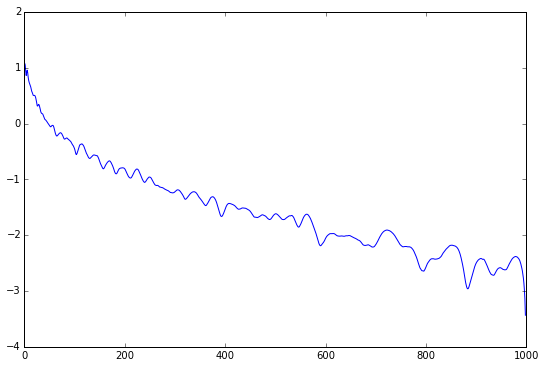

In [19]:
plot(log10(En_array-En_array.min()))

Convergence is much slower in this setting.